In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.7.0 pandas==1.3.4 scikit-learn==1.0 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.4


In [5]:
umi = sc.read_h5ad("/mnt/ccle_umi.h5ad")
umi.var.index = umi.var['Unnamed: 0']
umi_process = sc.read_h5ad('/mnt/ccle_umi_process.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### GMM Cluster on arm level CNA
#### Fit Gaussian Mixture model on the copy number state per arm to infer subclones 
compare log likelihood of bimodal vs unimodal gaussian 

In [394]:
def gmm_cluster_arm(patient_name):

    subtype_cna = pd.read_csv(f"/mnt/{patient_name}_cna.csv")
    subtype_cna.index = subtype_cna['arm']
    subtype_cna=subtype_cna.drop(columns = ['arm']).T
    subtype_cna['patient'] = patient_name

    gmm_list = []

    for p in subtype_cna.drop(columns = ['patient']).columns:

        gmm = GMM(n_components=2).fit(subtype_cna[[p]])
        class_pred = gmm.predict(subtype_cna[[p]])
        prob = [p[1] for p in gmm.predict_proba(subtype_cna[[p]])]

        gmm_null = GMM(n_components=1).fit(subtype_cna[[p]])

        df = pd.DataFrame({'data':subtype_cna[p].values, 
                           'GMM classification':class_pred, 
                           'class_0_size' : Counter(class_pred)[0], 
                           'class_1_size' : Counter(class_pred)[1], 
                           'class_0_mean': gmm.means_[0][0], 
                           'class_1_mean': gmm.means_[1][0], 
                           'prob':prob, 
                           'arm': p, 
                           'AIC': gmm.aic(subtype_cna[[p]]), 
                           'BIC' : gmm.bic(subtype_cna[[p]]),
                           'log_likelihood': gmm.score(subtype_cna[[p]]), 
                           'null_AIC': gmm_null.aic(subtype_cna[[p]]), 
                           'null_BIC' : gmm_null.bic(subtype_cna[[p]]),
                           'null_log_likelihood': gmm_null.score(subtype_cna[[p]]), 
                           'patient_name' : patient_name
                          })

        gmm_list.append(df)

    gmm_result = pd.concat(gmm_list)
    gmm_result['bimodal'] = gmm_result['log_likelihood'] > gmm_result['null_log_likelihood']
    gmm_result['bimodal_aic'] = gmm_result['null_AIC'] > gmm_result['AIC']
    gmm_result['bimodal_bic'] = gmm_result['null_BIC'] > gmm_result['BIC']
    gmm_result['likelihood_diff'] = gmm_result['log_likelihood'] - gmm_result['null_log_likelihood']
    gmm_result['diff_mean'] = abs(gmm_result['class_0_mean'] -  gmm_result['class_1_mean'])
    gmm_result['selected_arm'] = ((gmm_result['bimodal'] == True) & (gmm_result['bimodal_bic'] == True)& (gmm_result['bimodal_aic'] == True) &  (gmm_result['diff_mean'] > 0.2) & 
                                  (gmm_result['class_0_size']>10) & (gmm_result['class_1_size']>10))
    
    return gmm_result

In [395]:
def plot_gmm(gmm_result, arm_list):
    
    for p in arm_list:
        
        plt.subplots(figsize= (6,6))
        sns.histplot(data = gmm_result[gmm_result['arm'] == p], x= "data", hue = "GMM classification",bins = 40)
        plt.xlabel(f"Inferred copy number alteration \n chromosomal arm {p}")
        plt.show()

In [397]:
gmm_result_list = []

for p in cancer_type_cluster_df[cancer_type_cluster_df['subtype'] == True]['patient']:
    
    gmm_result = gmm_cluster_arm(patient_name = p )
    gmm_result_list.append(gmm_result)

In [398]:
gmm_result = pd.concat(gmm_result_list)

In [406]:
gmm_result[gmm_result['selected_arm'] == True].sort_values(by ="diff_mean",ascending = False).patient_name.unique()

array(['BICR6_UPPER_AERODIGESTIVE_TRACT', 'NCIH1568_LUNG',
       'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM', 'OSRC2_KIDNEY',
       'HUH28_BILIARY_TRACT', 'MDAMB436_BREAST',
       'SW1088_CENTRAL_NERVOUS_SYSTEM', 'NCIH1435_LUNG', 'PK45H_PANCREAS',
       'SNU46_UPPER_AERODIGESTIVE_TRACT', 'NCIH2444_LUNG', 'COLO741_SKIN',
       'UMUC1_URINARY_TRACT', 'ABC1_LUNG'], dtype=object)

In [408]:
gmm_result[ (gmm_result['selected_arm'] == True) & (gmm_result['patient_name'] == 'BICR6_UPPER_AERODIGESTIVE_TRACT' )].sort_values(by ="diff_mean",ascending = False).arm.unique()

array(['22q', '1p', '23p', '11p'], dtype=object)

In [409]:
gmm_result[ (gmm_result['selected_arm'] == True) & (gmm_result['patient_name'] == 'NCIH1568_LUNG' )].sort_values(by ="diff_mean",ascending = False).arm.unique()

array(['7q', '18q', '18p', '2q', '5p'], dtype=object)

In [410]:
gmm_result[ (gmm_result['selected_arm'] == True) & (gmm_result['patient_name'] == 'CCFSTTG1_CENTRAL_NERVOUS_SYSTEM' )].sort_values(by ="diff_mean",ascending = False).arm.unique()

array(['6q', '3p'], dtype=object)

In [413]:
gmm_result[ (gmm_result['selected_arm'] == True) & (gmm_result['patient_name'] == 'OSRC2_KIDNEY' )].sort_values(by ="diff_mean",ascending = False).arm.unique()

array(['19p', '9q', '12q', '17q'], dtype=object)

In [416]:
gmm_result[ (gmm_result['selected_arm'] == True) & (gmm_result['patient_name'] == 'HUH28_BILIARY_TRACT' )].sort_values(by ="diff_mean",ascending = False).arm.unique()

array(['8p', '15q', '7q', '10q', '7p'], dtype=object)

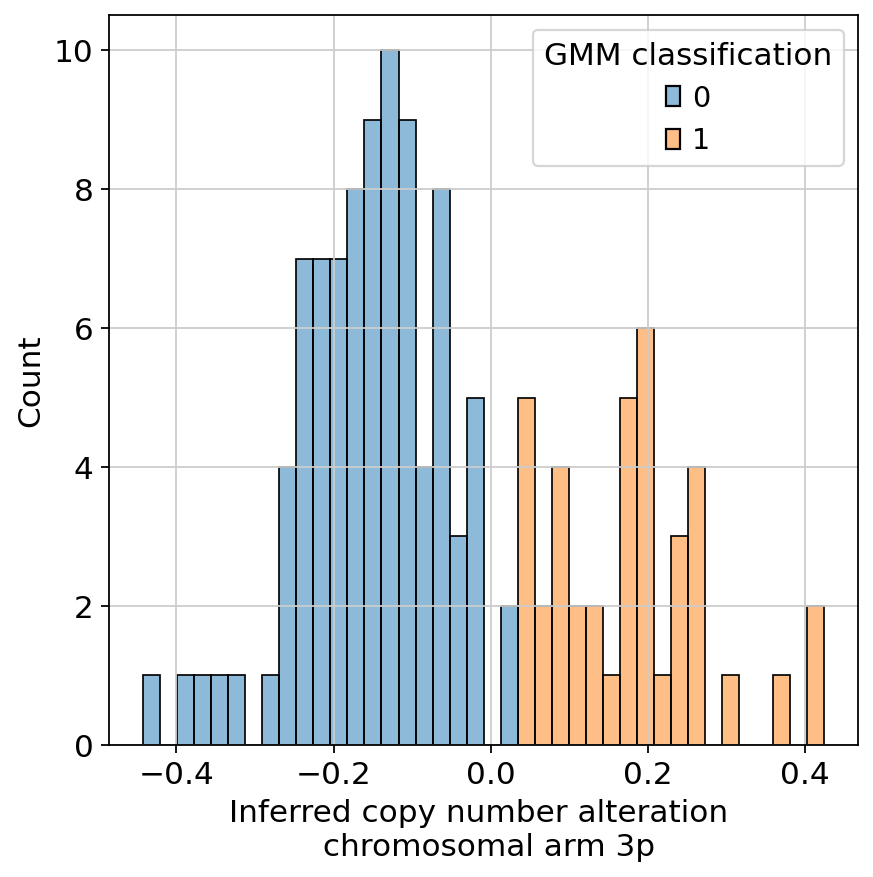

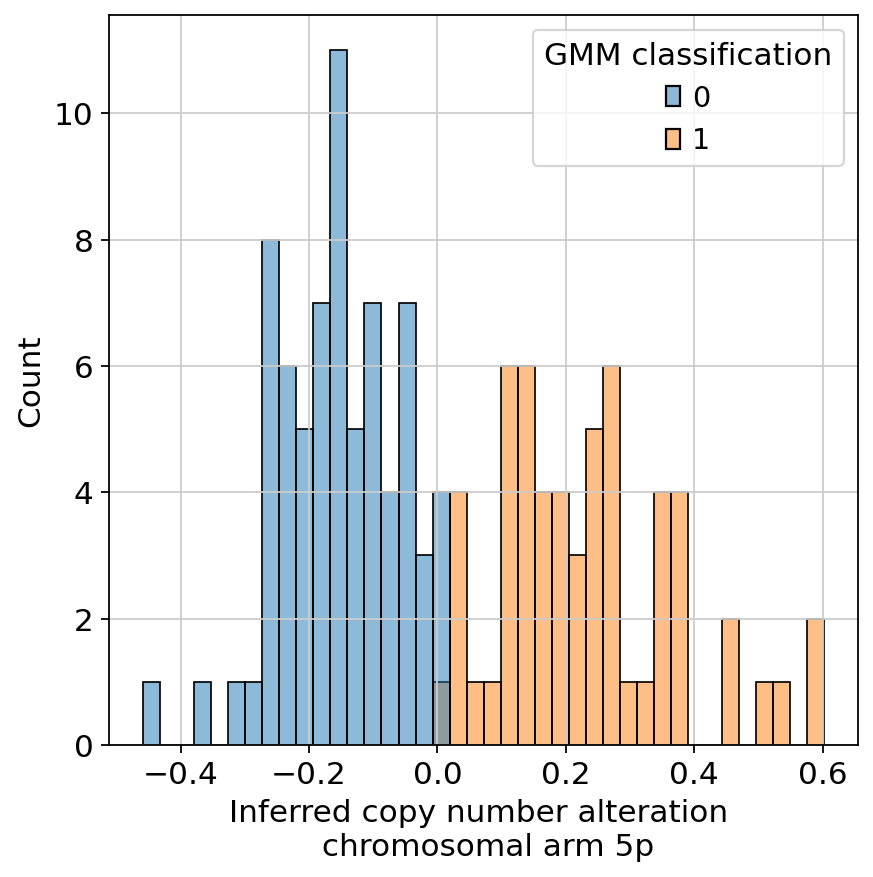

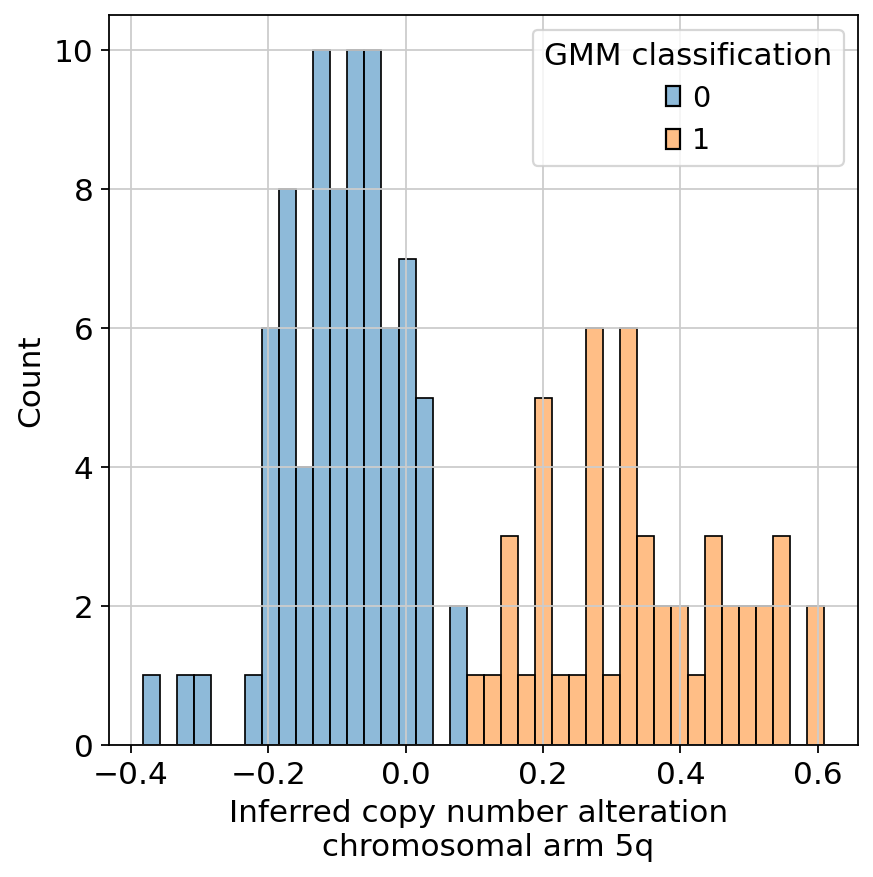

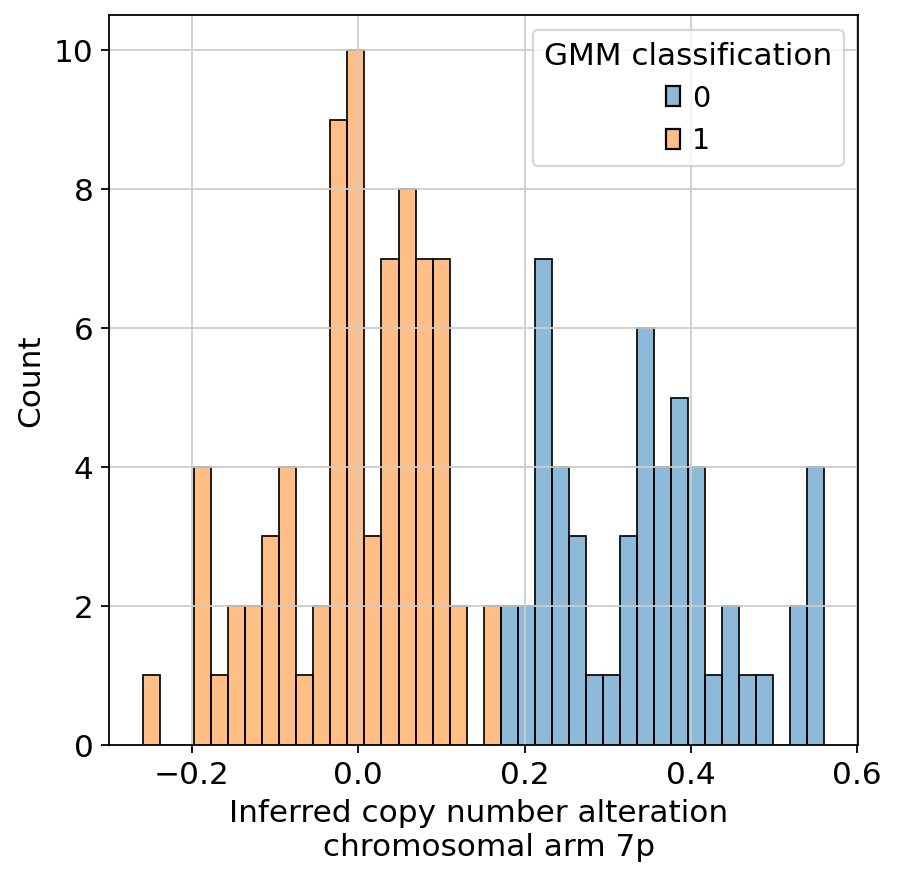

In [697]:
plot_gmm(gmm_result[gmm_result['patient_name'] =='SW1088_CENTRAL_NERVOUS_SYSTEM' ], arm_list =['3p','5p','5q', '7p'])

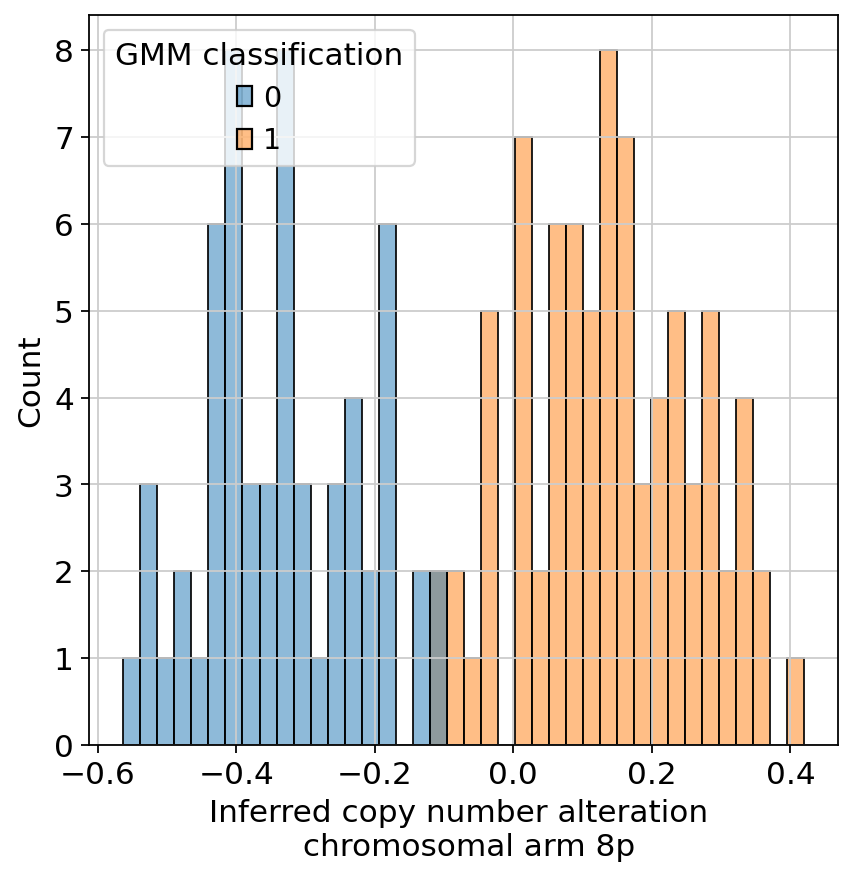

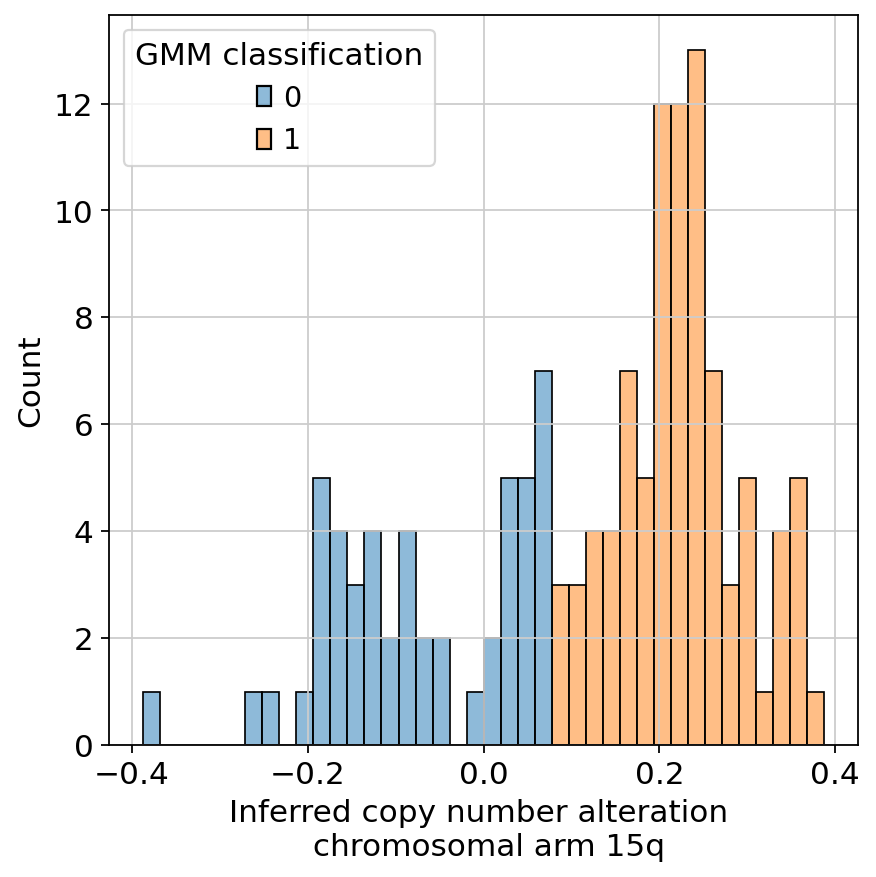

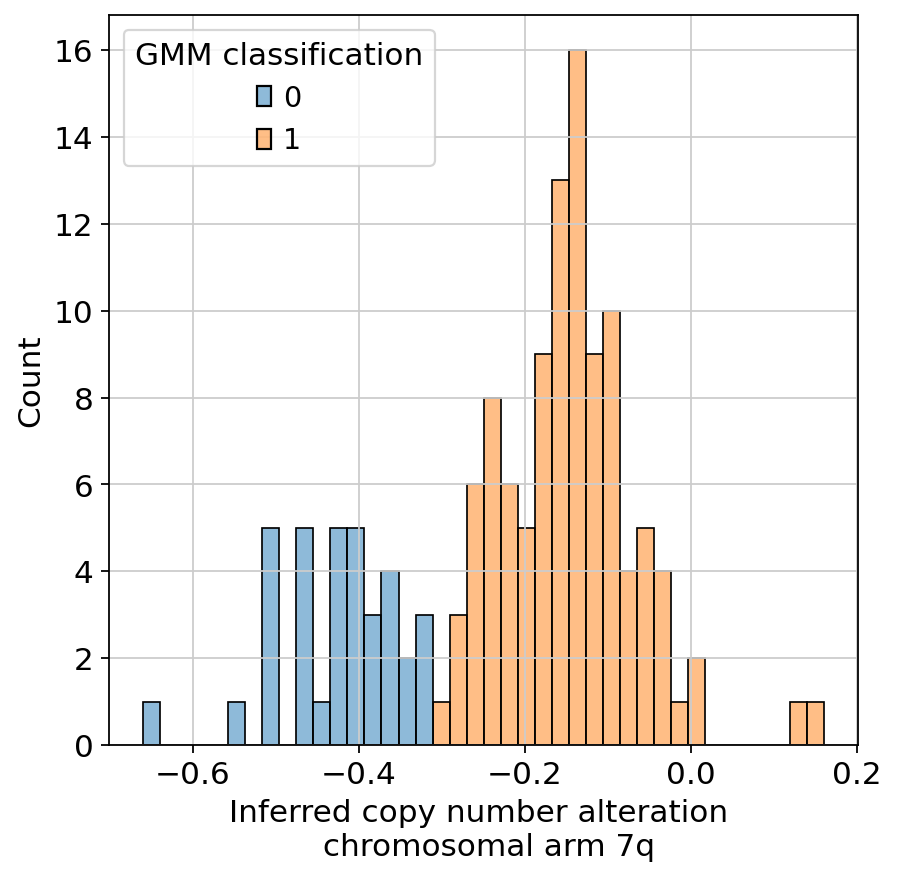

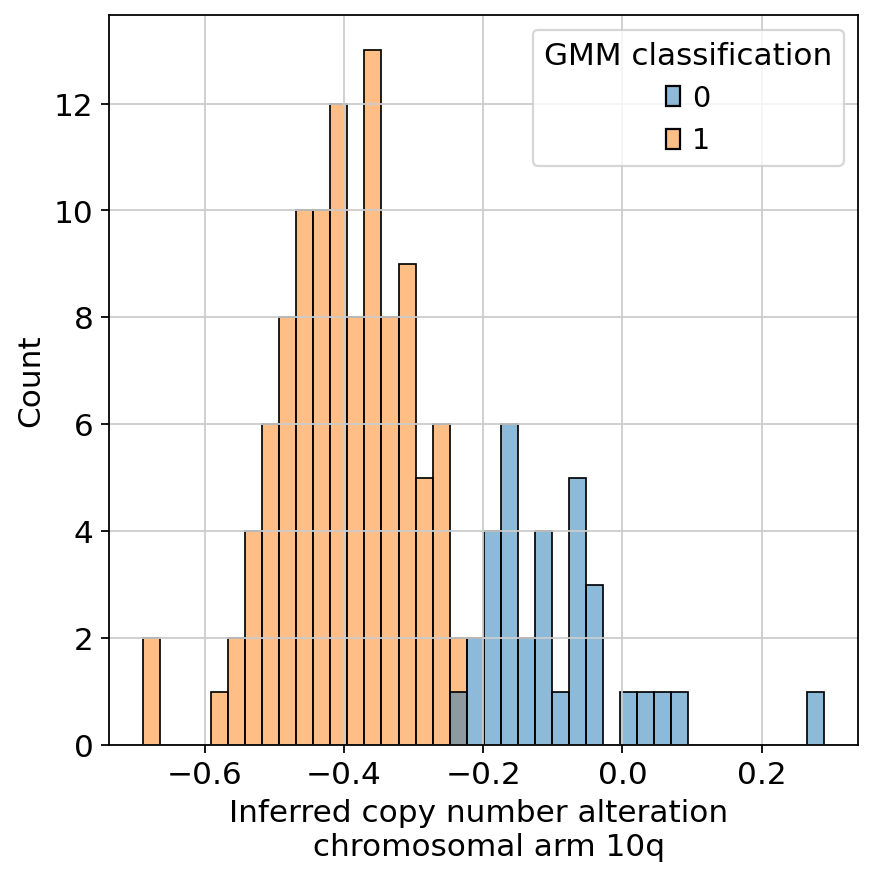

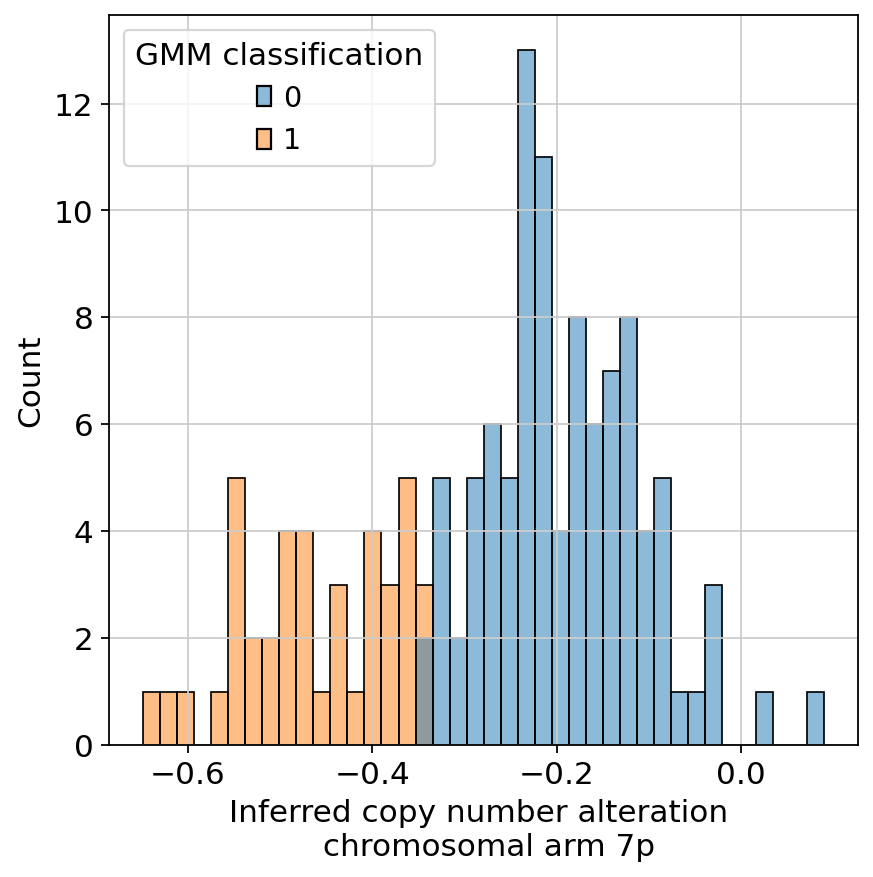

In [417]:
plot_gmm(gmm_result[gmm_result['patient_name'] =='HUH28_BILIARY_TRACT' ], arm_list =['8p', '15q', '7q', '10q', '7p'])

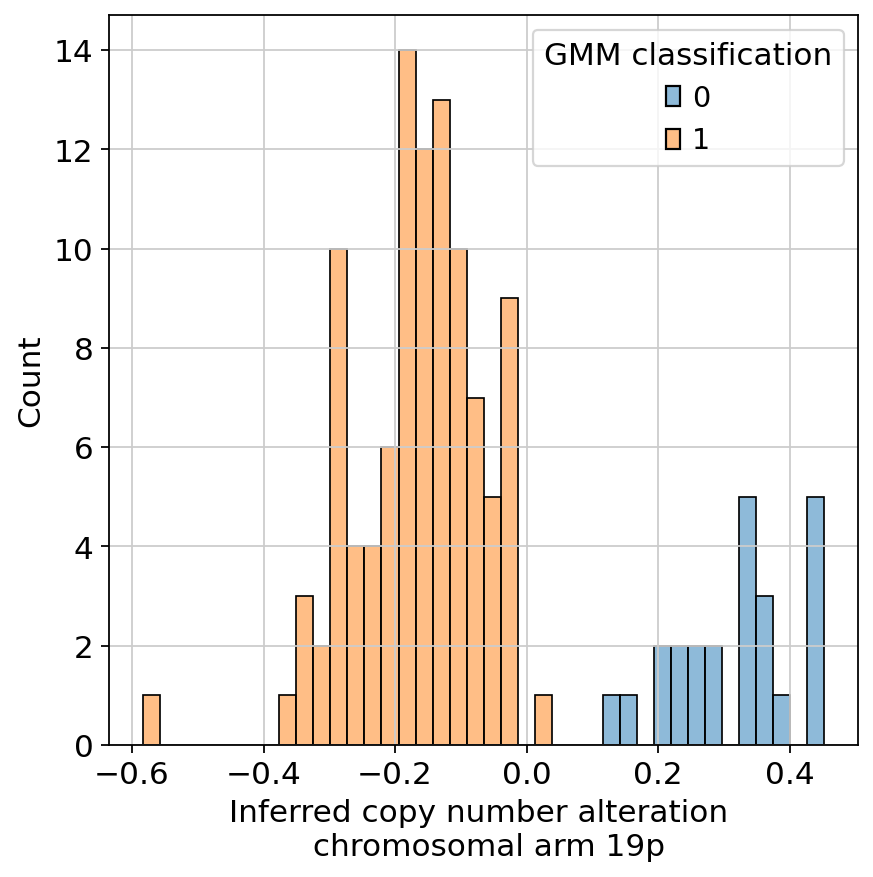

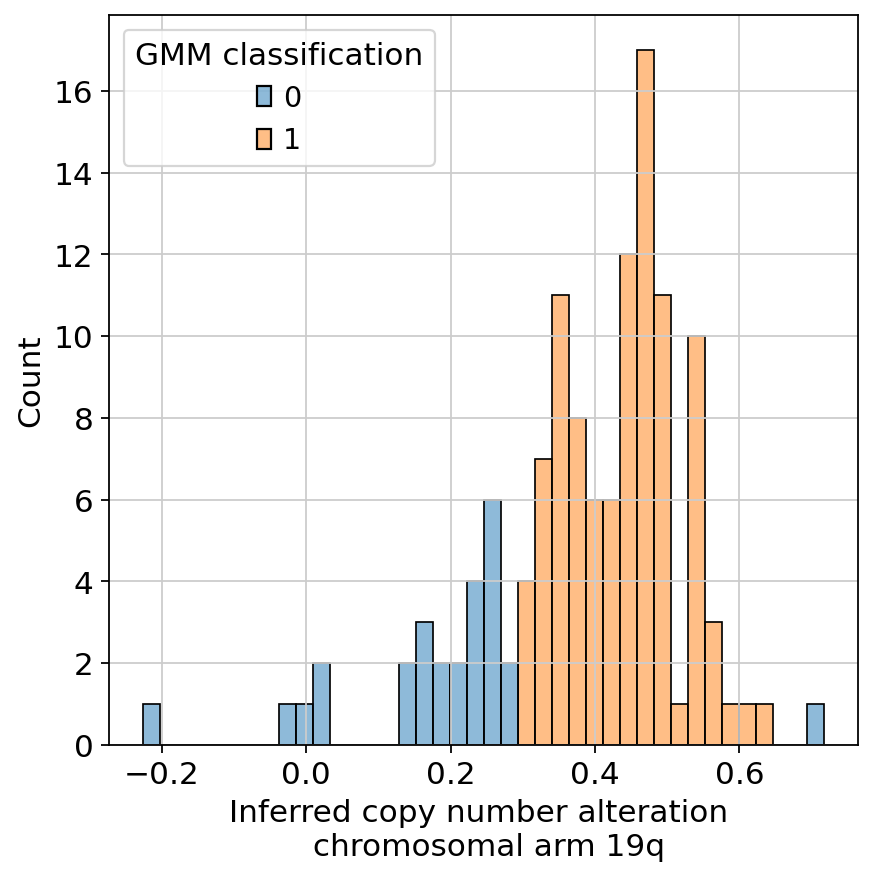

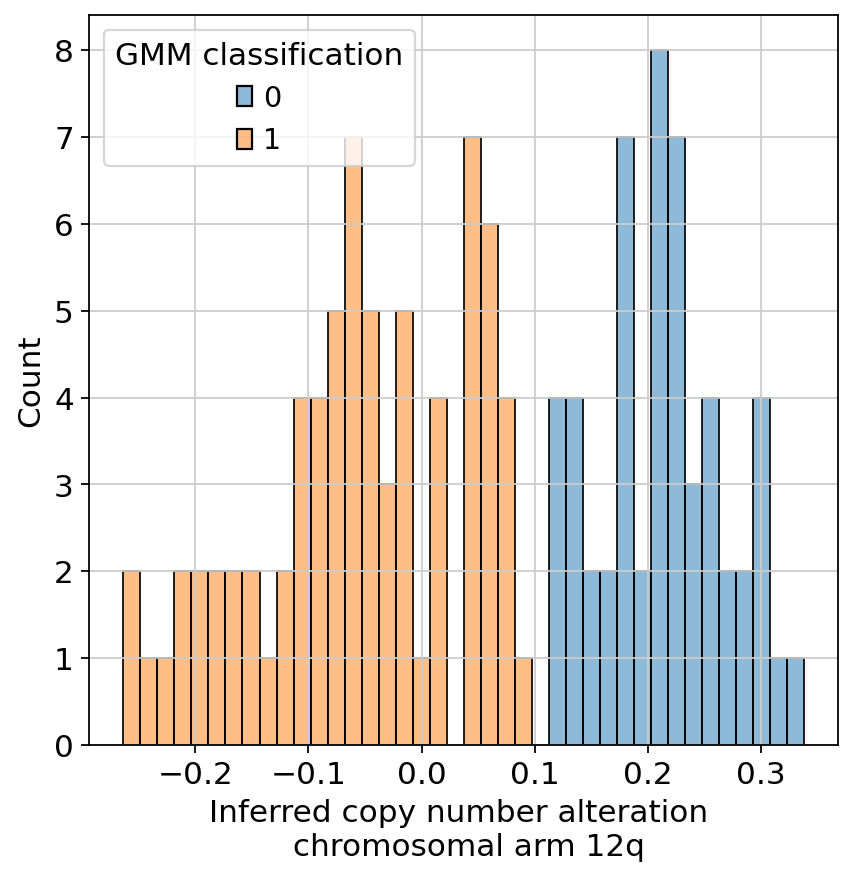

In [415]:
plot_gmm(gmm_result[gmm_result['patient_name'] =='OSRC2_KIDNEY' ], arm_list =['19p', '19q','12q'])

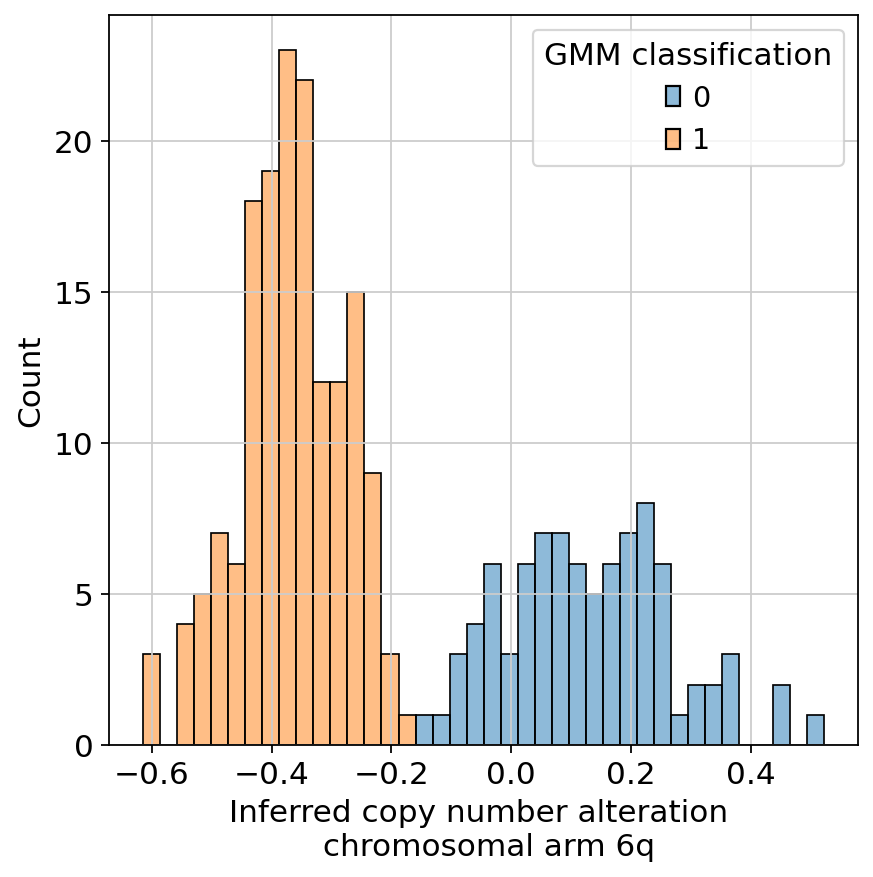

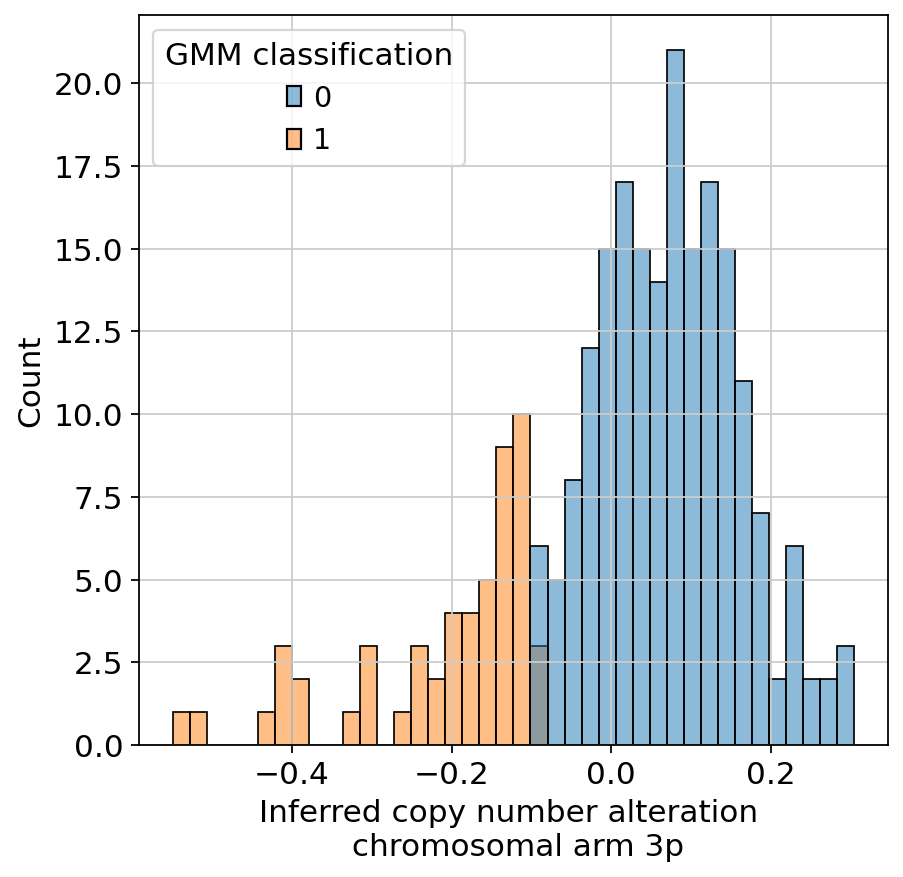

In [411]:
plot_gmm(gmm_result[gmm_result['patient_name'] =='CCFSTTG1_CENTRAL_NERVOUS_SYSTEM' ], arm_list =['6q', '3p'])

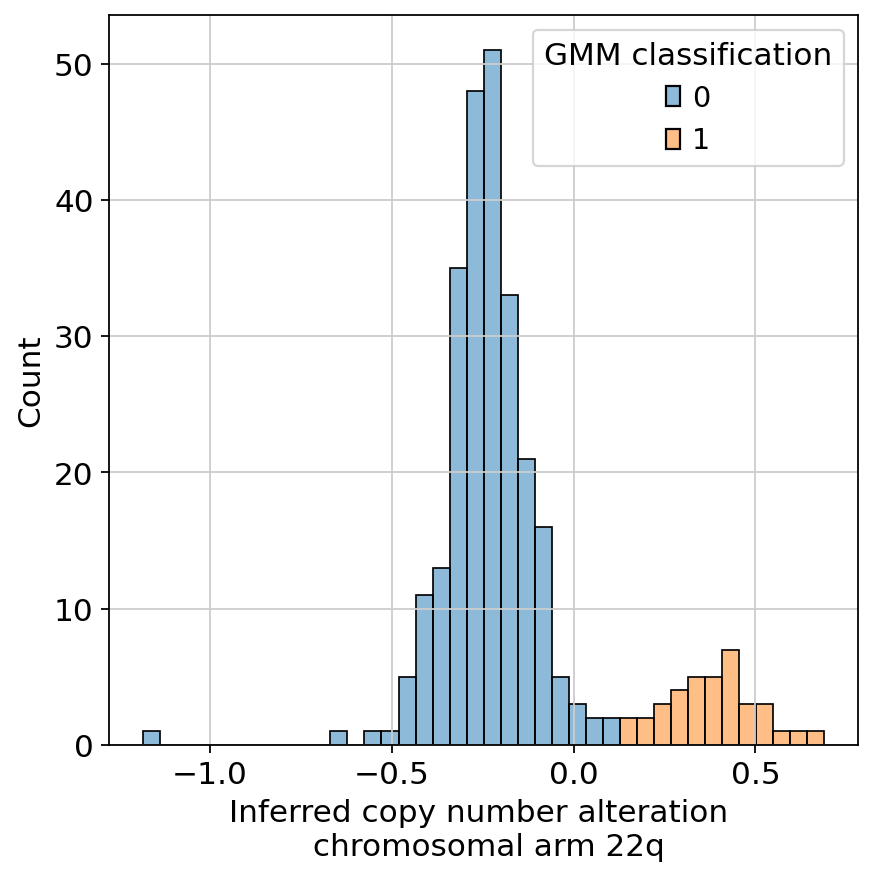

In [404]:
plot_gmm(gmm_result[gmm_result['patient_name'] =='BICR6_UPPER_AERODIGESTIVE_TRACT' ], arm_list =['22q'])